In [1]:
from gradient_descent import gradient_descent, minibatch_class
import utils
from utils import Poisson_reg
from utils import sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 
import sys 
from __future__ import print_function
import psutil
import multiprocessing
import concurrent.futures
import threading

import numpy as np
import torch
from torch import nn
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

### Some functions to compare different  models  

In [2]:
def compare_models_batch(modele,modele_batch, batch_size): 
    '''
    takes two models : modele and modele_batch and compare them. They are supposed to be trained.
    the batch size is the batch size that has been used to train model_batch. 
    modele should not have been trained with batches. 
    '''
    n,p = modele.Y.shape
    d = modele.beta.shape[0]
    ELBO = np.round(modele.current_ELBO,5)
    name = 'batch size = {},n = {}, p = {}, d = {}, With batch : last ELBO : {}, time : {}, Without batch : last ELBO : {}, time : {}.jpg'.format(batch_size,
                                         n,p,d,  np.round(modele_batch.current_ELBO,1), np.round(modele_batch.running_time,0),  np.round(modele.current_ELBO,1),np.round(modele.running_time,0))
    abscisse = np.arange(len(modele.MSE_Sigma_list))
    fig,ax = plt.subplots(4,1,figsize = (15,12))
    plt.subplots_adjust(hspace = 0.4)
    plt.suptitle(name)
    ax[0].plot(abscisse, modele_batch.MSE_Sigma_list, label = 'MSE with batch')
    ax[0].plot(abscisse, modele.MSE_Sigma_list, label = 'MSE without batch')
    ax[0].legend()
    ax[0].set_ybound( lower=0, upper=0.7)
    ax[0].set_title('MSE of Sigma. last MSE with batch :{} . last_MSE without batch : {}'.format(np.round(modele_batch.MSE_Sigma_list[-1],5), np.round(modele.MSE_Sigma_list[-1],5)))
    
    
    
    ax[1].plot(abscisse, modele_batch.MSE_beta_list, label = 'MSE with batch')
    ax[1].plot(abscisse, modele.MSE_beta_list, label = 'MSE without batch')
    ax[1].legend()
    ax[1].set_ybound( lower=0, upper=0.7)
    ax[1].set_title('MSE of beta. last MSE with batch :{} . last_MSE without batch : {}'.format(np.round(modele_batch.MSE_beta_list[-1],5), np.round(modele.MSE_beta_list[-1],5)))
    

    ax[2].plot(abscisse, modele_batch.ELBO_list, label = 'ELBO with batch')
    ax[2].plot(abscisse, modele.ELBO_list, label = 'ELBO without batch')
    ax[2].legend()
    ax[2].set_xscale('log')
    ax[2].set_title('ELBO')
    
    
    ax[3].plot(abscisse, np.array(modele.ELBO_list)-np.array(modele_batch.ELBO_list), label =  'ELBO without - ELBO with')
    ax[3].legend()
    ax[3].set_title('ELBO without batches - ELBO with batches')
    ax[3].axhline(y=0, c = 'red')
    ax[3].set_ybound( lower=-20, upper=20)
    plt.savefig(name)

    
def compare_models_tol(modele, modele_little,big_tolerance, little_tolerance): 
    '''
    same as above but for models that takes differents tolerance. 
    
    modele_little shoudl have a lower tolerance than modele 
    '''
    n,p = modele.Y.shape
    d = modele.beta.shape[0]
    ELBO = np.round(modele.current_ELBO,5)
    
    name = 'big tolerance = {}, smaller tolerance {},n = {}, p = {}, d = {}, precise step : last ELBO : {}, time : {}, inexact step : last ELBO : {}, time : {}.jpg'.format(big_tolerance,little_tolerance, 
                                         n,p,d,  np.round(modele_little.current_ELBO,1), np.round(modele_little.running_time,0),  np.round(modele.current_ELBO,1),np.round(modele.running_time,0))
    abscisse = np.arange(len(modele.MSE_Sigma_list))
    fig,ax = plt.subplots(4,1,figsize = (15,12))
    plt.subplots_adjust(hspace = 0.4)
    plt.suptitle(name)
    ax[0].plot(abscisse, modele_little.MSE_Sigma_list, label = 'MSE precise step')
    ax[0].plot(abscisse, modele.MSE_Sigma_list, label = 'MSE inexact step')
    ax[0].legend()
    ax[0].set_ybound( lower=0, upper=0.7)
    ax[0].set_title('MSE of Sigma. last MSE inexact step :{} . last_MSE precise step : {}'.format(np.round(modele.MSE_Sigma_list[-1],5),
                                                                                        np.round(modele_little.MSE_Sigma_list[-1],5)))
    
    
    ax[1].plot(abscisse, modele_little.MSE_beta_list, label = 'MSE precise step')
    ax[1].plot(abscisse, modele.MSE_beta_list, label = 'MSE inexact step')
    ax[1].legend()
    ax[1].set_title('MSE of beta. last MSE inexact step :{} . last_MSE precise step : {}'.format(np.round(modele.MSE_beta_list[-1],5), np.round(modele_little.MSE_beta_list[-1],5)))
    

    ax[2].plot(abscisse, modele_little.ELBO_list, label = 'ELBO precise step')
    ax[2].plot(abscisse, modele.ELBO_list, label = 'ELBO inexact step')
    ax[2].legend()
    ax[2].set_xscale('log')
    ax[2].set_title('ELBO')
    
    
    ax[3].plot(abscisse, np.array(modele.ELBO_list)-np.array(modele_little.ELBO_list), label =  'ELBO inexact step - ELBO precise step')
    ax[3].legend()
    ax[3].set_title('ELBO inexact step - ELBO precise ')
    ax[3].axhline(y=0, c = 'red')
    ax[3].set_ybound( lower=-20, upper=20)
    plt.savefig(name)
    



def print_model(modele): 
    'print some useful curves of the model modele'
    
    abscisse = np.arange(len(modele.MSE_Sigma_list))
    fig,ax = plt.subplots(4,1,figsize = (12,12))
    ax
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, modele.MSE_Sigma_list)
    Sigma_min = np.round(min(modele.MSE_Sigma_list),5)
    Sigma_argmin = np.argmin(modele.MSE_Sigma_list)
    ax[0].set_title('MSE of Sigma. last MSE :{} . best_MSE {}, argmin = {}'.format(np.round(modele.MSE_Sigma_list[-1],5), Sigma_min, Sigma_argmin))
    
    ax[1].plot(abscisse, modele.MSE_beta_list)
    beta_min = np.round(min(modele.MSE_beta_list),5)
    beta_argmin = np.argmin(modele.MSE_beta_list)
    ax[1].set_title('MSE of beta. last MSE :{} . best_MSE {}, argmin = {}'.format(np.round(modele.MSE_beta_list[-1],5), beta_min, beta_argmin))
    
    ax[2].plot(abscisse, modele.ELBO_list)
    ax[2].set_xscale('log')
    ax[2].set_title('ELBO')
    
    ax[3].plot(abscisse, modele.MSE_Sigma_list)
    ax[3].set_title('MSE of Sigma (x axis in log scale)')
    ax[3].set_xscale('log')
    

# PLN Model

In [10]:
class PLNmodel(): 
    '''
    PLN model. The goal of this class is to compute the parameter beta and Sigma of the PLN model. 
    We use here variationnal approximation since we can't compute the log likelihood of the 
    latent variables given the data. 
    '''
    
    
    def __init__(self, Sigma_init, beta_init, M_init, S_init): 
        
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  THE TYPE IS INT
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'Sigma_init' : initialization for Sigma. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
        '''
        
        # model parameters
        self.Sigma = torch.clone(Sigma_init)
        self.Sigma.requires_grad_(True)
        self.beta = torch.clone(beta_init)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) 
        self.S.requires_grad_(True)
        
        # some useful variables
        self.det_Sigma = torch.det(self.Sigma)
        self.inv_Sigma = torch.inverse(self.Sigma)
        
        # optimizer for the VE_step
        self.VE_step_optimizer = torch.optim.Adam([self.S,self.M], lr = 0.002)
        self.VE_step_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.VE_step_optimizer, patience = 3, factor = 0.9)
        
        #optimizer for the M_step
        self.M_step_optimizer = torch.optim.Adam([self.beta], lr = 0.01)
        self.M_step_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.M_step_optimizer, patience = 3, factor = 0.9)        
        
        #optimizer for a full gradient ascent
        self.full_optimizer = torch.optim.Adam([self.S,self.M,self.beta])
        
        # just to stocke the parameters
        self.params = {'M': self.M, 'S' : self.S, 'beta' : self.beta}
        
        # to stock the 
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        
        

        
    # we define here the gradients computed manually as a sanity check. We can check that they are equals 
    # to the gradients computed with the autodifferentiation of pytorch (diff = 1e-15)
    def grad_Sigma(self): 
        with torch.no_grad():
            self.inv_Sigma = torch.inverse(self.Sigma)
            grad = -self.n/2*(self.inv_Sigma)# + torch.diag(torch.diagonal(self.inv_Sigma))) on a enlevé car avec ça ca match avec pytorch. 
            grad += 1/2*(sum([self.inv_Sigma@(torch.outer(self.M[i,:],self.M[i,:])+ torch.diag(self.S[i,:]))@self.inv_Sigma  for i in range(self.n)]))
        return grad
    def grad_M(self): 
        with torch.no_grad():
            grad = -torch.mm(self.M,self.inv_Sigma)
            grad -= torch.exp(self.O + torch.mm(self.covariates,self.beta) + self.M + torch.pow(self.S,2)/2)
            grad += self.Y 
        return grad 
    def grad_S(self):
        with torch.no_grad():
            grad = -1/2*torch.mm(torch.ones((self.n,self.p)), torch.diag(torch.diag(self.inv_Sigma)))
            grad-= torch.mul(self.S,torch.exp(self.O + torch.mm(self.covariates,self.beta) + self.M + torch.pow(self.S,2)/2))
            grad += 1/2*torch.div(1,self.S)
        return grad 
    def grad_beta(self): 
        with torch.no_grad():
            grad = - torch.mm(self.covariates.T,torch.exp( self.O + self.M + torch.pow(self.S,2)/2 + torch.mm(self.covariates,self.beta)))
            grad += torch.mm(self.covariates.T,self.Y.double())
        return grad 
    
        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0];self.O = data[1];self.covariates = data[2]
        self.n, self.p = self.Y.shape
    
    def train_step(self, optimizer, Y_,covariates_, O_,M_,S_,Sigma_, beta_): 
        '''
        do one step on gradient ascent. We will optimize only the parametrs of the optimizer. 
        
        args : 
                'optimizer' torch.optim.optimizer object. this function will update the parameters of this optimizer. 
                
                'Y_' size (batch_size, p). 
                'covariates' size (batch_size, d)
                'O_' size (batch_size, p)
                'M_' size (batch_size, p)
                'S_' size (batch_size, p)
                'Sigma_' size (p,p)
                'beta_' size(batch_size, p)
                
        returns : 
        
                'loss' float. the loss computed. correspond to -ELBO 
        '''
        optimizer.zero_grad()
        loss = -self.compute_ELBO(Y_, covariates_, O_, M_, S_,Sigma_,beta_)
        loss.backward()
        if torch.isnan(loss).item() == True : 
            print('NAN')
        else : self.last_param = self.params 
        optimizer.step()
        return loss 

   
    def get_batch(self,batch_size): 
        '''
        get the batches required to do a  minibatch gradient ascent. the batches are generate for the
        variables Y covariates 0 M and S (only those who depends on n). It is a generator to handle memory. 
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one since the rest of the division is
                    not always an integer)
        '''
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        self.batch_size = batch_size
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    self.M[indices[i*batch_size: (i+1)*batch_size]], 
                    self.S[indices[i*batch_size: (i+1)*batch_size]])
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]],
                    self.M[indices[-last_batch_size:]], 
                    self.S[indices[-last_batch_size:]])
            
    
    def full_grad_ascent(self, data, lr = None, tolerance = 2, N_iter = 500, verbose = True): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 
        
        args :  'data' the data i.e. a list of 3 elements Y O and covariates in this order
                
                'lr' : float.  a learning rate if we want to set the optimizer learning rate to a certain lr. If None, 
                      it will take the actual learning_rate of the optimizer. 
                'tolerance': float. the threshold we set to stop the algorithm. It will stop if the norm of each gradient's parameter 
                             is lower than this threshold, or if we are not improving the loss more than tolerance. 
                'N_iter': int. the Maximum number of iterations we are ready to do. 
                
                'Verbose' : bool. if True, will print some messages useful to interpret the gradient ascent. If False, nothing will be printed. 

        
        returns : the parameters optimized. 
        '''
        self.extract_data(data)
        
        # we set the gradient to zero just to make sure the gradients are properly calculated
        self.full_optimizer.zero_grad()
        
        if lr is not None : # if we want to set a threshold, we set it. Ohterwise, we skip this condition and keep the actual learning_rate
            self.full_optimizer.param_groups[0]['lr'] = lr 
            
        
        stop_condition = False 
        i = 0
        old_loss = 0 
        
        while i < N_iter and stop_condition == False: 
            
            loss = self.train_step(self.full_optimizer, self.Y, self.covariates, self.O, self.M, self.S, self.Sigma, self.beta)
            i += 1 
            
            # condition to see if we have reach the tolerance threshold
            if max([torch.norm(param.grad) for param in self.params.values()]) < tolerance  or abs(loss - old_loss) < tolerance : #and i > 10:
                stop_condition = True 
            old_loss = loss 
            
            #update Sigma with the closed form. 
            with torch.no_grad(): 
                self.Sigma = 1/self.n*(torch.sum(torch.stack([torch.outer(self.M[i,:],self.M[i,:]) + torch.diag(self.S[i,:])  for i in range(self.n)]), axis = 0))
            
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss)
            
            if verbose and i % 100 == 0 : 
                print('iteration : ', i)
                self.print_stats(loss, self.params, self.full_optimizer)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
            


        if verbose : # just print some stats if we want to 
            if stop_condition : 
                print('---------------------------------Tolerance reached in {} iterations'.format(i))
            else : 
                print('---------------------------------Maximum number of iterations reached')
            self.print_stats(loss,self.params, self.full_optimizer)   
        
        return self.params

    def print_stats(self, loss, params, optimizer): 
        '''
        small function that print some stats. 
        
        It will print the actual learning rate of the optimizer, the actual log likelihood 
        and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
        when we are close to the optimum. 
        '''
        print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
        print('---------------------------------log likelihood :', - loss.item())
        for param_name, param in params.items(): 
            print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
    
    
    def VEM(self,data, number_VEM_step ,batch_size,   tolerance = 0.1, beginning_VE_step_lr = 0.002, beginning_M_step_lr = 0.01, 
                requires_init = False,N_epoch_VE = 50, N_epoch_M = 75, verbose = False): 
        '''
        function to optimize both the variational parameters and the model parameters.
        We alternate between two steps : Variational step (VE_step) and Maximization step (M_step). 
        
        
        args : 
            'number_VEM_step' : int . Number of times we want to do the VEM step, i.e. alternate between VE step and M step. 
                                The greater the better the approximation, the greater the longer time it takes. 
            
            'beginning_VE_step_lr' : float. the beginning of the learning for the VE_step. The VE will start with this lr. 
            'beginning_M_step_lr' : float. Same for beta, the M step will start with this lr. 
            
       returns : 
               M_S_lr, beta_lr : the learning rates of both steps, so that we can continue after that with the appropriate learning rates.  
        ''' 
        
        self.running_time = time.time()
        
        # we first extract the data. 
        self.extract_data(data)
        
        self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
        self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
        self.ELBO_list.append(1)
        
        if requires_init : 
            print('Initialisation ... ')
            clf = Poisson_reg()
            for j in range(p): 
                Y_j = self.Y[:,j]   
                O_j = self.O[:,j]
                
                clf.fit_torch(O_j,self.covariates,Y_j, verbose = False , Niter_max = 500, lr = 0.1)
                with torch.no_grad():
                    self.beta[:,j] = clf.beta
            print('Initialisation finished')
            
        # we do as many VEM_step we are asked to. 
        for i in range(number_VEM_step): 
            #M STEP
            # closed form for Sigma, we don't need to optimize
            with torch.no_grad(): 
                self.Sigma = 1/self.n*(torch.sum(torch.stack([torch.outer(self.M[i,:],self.M[i,:]) + torch.diag(self.S[i,:])  for i in range(self.n)]), axis = 0))
                #self.beta = torch.mm(torch.inverse(torch.mm(self.covariates.T,self.covariates)),torch.mm(self.covariates.T,self.M))
            #gradient ascent for beta 
            self.torch_gradient_ascent(self.M_step_optimizer, self.M_step_scheduler, 
                                       lr = beginning_M_step_lr, tolerance = tolerance, N_epoch= N_epoch_M, verbose= verbose, batch_size = batch_size )
            #VE STEP
            #gradient ascent for M and S 
            self.torch_gradient_ascent(self.VE_step_optimizer, self.VE_step_scheduler, lr = beginning_VE_step_lr,
                                    tolerance= tolerance, N_epoch= N_epoch_VE, verbose= verbose)
            
            # we append the MSE to keep track of the progression. Note that true_Sigma and true_betais unknown in practice. 
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(self.current_ELBO)
            if i %  100 == 0 : 
                print('-------UPDATE-------', batch_size, 'N_epoch :VE ',N_epoch_VE)
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(self.current_ELBO,5))
        
        #keep track of the runningtime 
        self.running_time = time.time()- self.running_time
        return self.VE_step_optimizer.param_groups[0]['lr'],self.M_step_optimizer.param_groups[0]['lr']        
    
    def torch_gradient_ascent(self,optimizer, scheduler, lr = None, tolerance = 2, N_epoch = 500, verbose = True, batch_size = None ): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 
        
        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 
                'scheduler' : torch.optim.lr_scheduler.  scheduler for the optimizer above. 
                
                'lr' : float.  a learning rate if we want to set the optimizer learning rate to a certain lr. If None, 
                      it will take the actual learning_rate of the optimizer. 
                'tolerance': float. the threshold we set to stop the algorithm. It will stop if the norm of each gradient's parameter 
                             is lower than this threshold, or if we are not improving the loss more than tolerance. 
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'Verbose' : bool. if True, will print some messages useful to interpret the gradient ascent. If False, nothing will be printed. 
                
                'batch_size' : int or None. If None, the batch size will be n, so it will be a classical vanilla algorithm. 
                              if int, we will split the data set in batch size and do a gradient step for each mini_batch. 
                              
        
        returns : the parameters optimized. 
        '''
        
        
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()
        
        if lr is not None : # if we want to set a threshold, we set it. Ohterwise, we skip this condition and keep the actual learning_rate
            optimizer.param_groups[0]['lr'] = lr 
            
        #if batch_size is None, we take n. 
        if batch_size == None : 
            batch_size = self.Y.shape[0]
        
        stop_condition = False 
        i = 0
        old_epoch_loss = 1.
        
        while i < N_epoch and stop_condition == False: 
            epoch_loss = 0.
            # we run through the whole dataset. if batch_size was None, this loop contains only one element. 
            for Y_b, covariates_b, O_b, M_b, S_b in self.get_batch(batch_size): 
                epoch_loss += self.train_step(optimizer, Y_b, covariates_b, O_b, M_b, S_b, self.Sigma,self.beta)
            if verbose and i % 25 == 0 : 
                self.print_stats(epoch_loss, self.params, optimizer)
            i += 1
            scheduler.step(epoch_loss)
            # condition to see if we have reach the tolerance threshold
            if  abs(epoch_loss.item() - old_epoch_loss) < tolerance : #and i > 10 and max([torch.norm(param.grad) for param in params]) < tolerance  or
                #if max([torch.norm(param.grad) for param in params]) < tolerance  or abs(loss.item()- old_loss)>  tolerance :
                stop_condition = True 
            old_epoch_loss = epoch_loss
            
        #keep track of the ELBO 
        self.current_ELBO = -epoch_loss.item()
        
        if verbose : # just print some stats if we want to 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch)
            self.print_stats(epoch_loss, self.params, optimizer)
        return self.last_param
    def compute_ELBO(self, Y, covariates,O,M,S,Sigma,beta): 
        ''' 
        computes the ELBO. We simply apply the formula given above. 
        '''
        batch_size = Y.shape[0]
        inv_Sigma = torch.inverse(Sigma)
        tmp = -batch_size/2*torch.log(torch.det(Sigma))
        
        # formula with the quadratic function
        tmp -=1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))   # we can simplify here, takes too much time 
                                                                                           # we should remove the diagonal and do a more efficient multiplication
                                            
        Gram_matrix = torch.mm(covariates,beta) # matrix with term (i,j): <x_i,beta_j>
        
        Exp_moment = torch.exp(M + torch.pow(S,2)/2)
        
        tmp += torch.sum(-torch.exp(O + Gram_matrix + M + torch.pow(S,2)/2) + torch.multiply(Y, O + Gram_matrix + M))
        
        for i in range(batch_size): 
            tmp += 1/2* torch.log(S[i,:].prod())
            tmp -= 1/2 * torch.trace(torch.multiply(inv_Sigma,S[i,:]))
        return tmp
    

## Generation des données. 

In [4]:
#extraction des données 
Y_tricho = torch.from_numpy(read_csv('trichoptera.csv', sep=',').to_numpy())
O_tricho = torch.outer(Y_tricho.sum(1), torch.ones(Y_tricho.shape[1]))/1000

n_tricho,p_tricho = Y_tricho.shape 
d_tricho = 4
covariates_tricho = torch.ones((n_tricho,d_tricho)) # attention prendre que des 1 n'est pas une bonne solution

data_tricho = [Y_tricho,O_tricho, covariates_tricho]

In [5]:
d = 4 # nb of cavariates
n = 500; p = 30

In [6]:
true_Sigma = torch.from_numpy(toeplitz(0.5**np.arange(p)))
true_beta = torch.randn(d, p)


covariates = torch.rand((n,d))
O = 1 + torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled = torch.from_numpy(sample_model.sample(true_Sigma,true_beta, O, covariates)) 

data = [Y_sampled, O, covariates]

In [7]:
torch.manual_seed(1)

noise = torch.randn(p,p) 
Sigma_init =  (noise+ noise.T)
beta_init = torch.rand((d, p))

M_init = torch.ones((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.ones((n,p))/8 # some random values to initializ. we divise to avoid nan values 

# Inférence

### gradient descent on all the parameters 

(except $\Sigma$ that is updated with a closed form) 

In [11]:
model_full = PLNmodel(Sigma_init, beta_init, M_init, S_init)
model_full.full_grad_ascent(data, lr = 0.01, tolerance = 2, N_iter = 10, verbose = True)

---------------------------------Maximum number of iterations reached
---------------------------------lr : 0.01
---------------------------------log likelihood : 422550.5166734666
---------------------------------grad_M_norm :  8934.077
---------------------------------grad_S_norm :  82.657
---------------------------------grad_beta_norm :  67857.166


{'M': tensor([[-0.0822, -0.0891, -0.0870,  ..., -0.0894, -0.0894, -0.0887],
         [-0.0887,  0.1072, -0.0881,  ...,  0.1099,  0.1099,  0.1092],
         [ 0.0444, -0.0893, -0.0768,  ...,  0.1057,  0.1096, -0.0860],
         ...,
         [-0.0884,  0.1098, -0.0423,  ..., -0.0902,  0.1085, -0.0870],
         [-0.0885,  0.1091,  0.1061,  ..., -0.0901,  0.1092, -0.0012],
         [-0.0886,  0.0949, -0.0885,  ..., -0.0901,  0.1074, -0.0795]],
        requires_grad=True),
 'S': tensor([[0.1180, 0.1411, 0.1363,  ..., 0.1352, 0.1330, 0.1328],
         [0.0975, 0.1349, 0.1325,  ..., 0.1132, 0.1267, 0.1226],
         [0.1112, 0.1406, 0.1378,  ..., 0.1343, 0.1295, 0.1280],
         ...,
         [0.0947, 0.1322, 0.1293,  ..., 0.1070, 0.1241, 0.1145],
         [0.0944, 0.1325, 0.1251,  ..., 0.1121, 0.1223, 0.1220],
         [0.0836, 0.1339, 0.1327,  ..., 0.1160, 0.1226, 0.1231]],
        requires_grad=True),
 'beta': tensor([[ 0.8293,  0.3551,  0.3611,  0.3397,  0.7102,  0.6318,  0.3690,  0.77

### VEM algorithm without batch

In [12]:
model = PLNmodel(Sigma_init, beta_init, M_init, S_init)
%time model.VEM(data, number_VEM_step = 2,tolerance= 0.01, batch_size = None, requires_init = False, N_epoch_VE = 100, N_epoch_M = 100, beginning_VE_step_lr=0.005, beginning_M_step_lr = 0.1 , verbose = False) 

-------UPDATE------- None N_epoch :VE  100
 MSE with Sigma :  0.04674
 MSE with beta :  0.26293
ELBO :  724881.6768
CPU times: user 55.6 s, sys: 58.4 ms, total: 55.6 s
Wall time: 33.2 s


(0.005, 0.09000000000000001)

### VEM algorithm with batch size 

In [ ]:
model_batch  = PLNmodel(Sigma_init, beta_init, M_init, S_init)
%time model_batch.VEM(data, number_VEM_step = 2,tolerance= 0.01, batch_size = 50, requires_init = False, N_epoch_VE = 100, N_epoch_M = 100, beginning_VE_step_lr=0.005, beginning_M_step_lr = 0.1 , verbose = False) 

sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$\Sigma :  (p,p)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

$M : (n,p)$

$S : (n,p)$ . Should be seen as $(n,p,p)$ but since all the $n$  matrix $(p,p)$ are diagonal, we only need $p$ points to encode it.

## The Poisson lognormal (PLN) model


- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are iid (no spatial structure):
$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$


The parameter of the model is $\theta = (\beta, \Sigma)$. 

Since the model depends on latent variables, we want to apply the EM algortihm. However, EM requires to compute the following : 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\Sigma}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$

Which is intractable in practice. 

We have two alternatives here. The first one is an approximation of this integral via MCMC methods. The second one is the variationnal approach. We adopt here the second approach. 

The goal of variationnal approach is to approximate $p_{\theta}(Z \mid Y)$ with some law $q^{\star}(Z)$ from which we can compute the expectation with respect to $\theta$. 


We find such a law by maximizing the Evidence Lower BOund (ELBO), that is : 
$$ 
q^{\star} = \underset{q \in \mathcal{Q}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$


Where $\mathcal{Q}$ is a set of distributions. 
The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

# VEM for PLN 

We consider 
$$
\mathcal{Q}_{\text {Gauss }}=\{q: q=\mathcal{N}(m, S)\}
$$

The parameters $M = (m_i)_{1\leq i \leq n} \in \mathbb{R}^{n\times p}$  and $ S = (S_i)_{1\leq i \leq n} \in \mathbb{R}^{n\times p} $ are called variational parameters whereas $\theta = (\beta,\Sigma)$ is called model parameter.  

The ELBO can be computed as : 


<br>
<br>


$$
\begin{aligned}
J_{\theta, q}(Y)=& \sum_{i} \mathbb{E}_{q_{i}}\left[\log p_{\theta}\left(Z_{i}\right)\right]+\sum_{i} \mathbb{E}_{q_{i}}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right]+\sum_{i} \mathcal{H}\left[\mathcal{N}\left(m_{i}, S_{i}\right)\right] \\
=&-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} \mathbb{E}_{\mathcal{N}\left(\cdot m_{i}, S_{i}\right)}\left[Z_{i}^{\top} \Sigma^{-1} Z_{i}\right] \\
&+\sum_{i, j} \mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, S_{i}\right)}\left[-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right] \\
&+\frac{1}{2} \sum_{i} \log \left|S_{i}\right|+\mathrm{cst}
\end{aligned}
$$
We can evaluate some moments of $Z$ : 
$$
\begin{aligned}
\mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, s_{i}\right)}\left(Z_{i}\right) &=m_{i}, & \mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, S_{i}\right)}\left(Z_{i}^{\top} \Sigma^{-1} Z_{i}\right)=m_{i}^{\top} \Sigma^{-1} m_{i}+\operatorname{tr}\left(\Sigma^{-1} S_{i}\right) \\
\mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, S_{i}\right)}\left(e^{Z_{i j}}\right) &=\exp \left(m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right) &
\end{aligned}
$$

We then get : 

$$
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+\sum_{i, j}-\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|S_{i}\right|+c s t .
\end{aligned}
$$


% the problem is convex if the S_i are diagonals. %

We have a closed form for the $\Sigma$ step, that is : 

$$
\widehat{\Sigma}=\frac{1}{n} \sum_{i}\left(m_{i} m_{i}^{\top}+S_{i}\right)
$$

For $\beta$, we have the following : 



$$
\nabla _{\beta}=-X^{\top} \exp \left(0+M+\frac{S \odot S}{2}+X \beta\right)+\frac{1}{2} X^{\top} Y
$$

However, we don't have any closed form for the VE step. 

We consider now $S$ as $(n,p)$ matrix. Indeed, the $S_i$ are supposed diagonal matrices so we only need $p$ points to encode each of them. Considering $S$ this way is simpler for calculus. Here are the gradients with respect to the variational parameters. 

$$
\nabla_{M} J=-M \Sigma^{-1}-\exp \left(O+x \beta+M+\frac{S \odot S}{2}\right)+Y
$$

$$
\nabla_{S} J=-\frac{1}{2}\mathbb{1}_{n}\mathbb{1}_{p}^{T} D_{\Sigma^{-1}}-S\odot  \exp \left(0+X \beta+M+\frac{S \odot  S}{2}\right)+\frac{1}{2} \frac{1}{S}
$$


We denote $D_{\Sigma^{-1}}$ the diagonal matrix composed of the diagonal of $\Sigma^{-1}$. The exponential is applied component-wise, as well as the division $\frac 1 S$. 












In [139]:
print('MSE beta : ', torch.mean((model.beta - true_beta)**2))
print('beta of the model : \n', model.beta)
print('true_beta : \n', true_beta)
print('\n \n ')
print('MSE Sigma : ', torch.mean((model.Sigma-true_Sigma)**2))
print('Sigma of the model : \n', model.Sigma)
print('true_Sigma : \n', true_Sigma)


MSE beta :  tensor(0.0987, grad_fn=<MeanBackward0>)
beta of the model : 
 tensor([[ 5.8360e-01,  4.1033e-01,  1.0620e+00,  3.9056e-01, -8.7853e-01,
         -2.1751e-01, -1.4860e+00,  1.9492e-01,  7.0599e-01,  3.4965e-01],
        [-6.7999e-01, -1.3128e-02, -1.4335e+00, -8.3641e-01,  2.9998e-01,
         -9.6386e-01,  1.1049e-01,  4.3667e-01,  1.7395e+00,  4.6980e-01],
        [ 1.7055e+00, -3.0708e-01,  1.0171e+00, -1.5144e+00, -7.6214e-01,
          1.3580e+00,  1.1788e+00,  1.9493e-01,  4.5231e-01,  2.3776e+00],
        [ 2.0321e+00,  5.1470e-01,  6.1020e-01,  7.4580e-01,  1.3954e-01,
          1.3610e+00,  2.4320e-01,  7.1867e-01, -1.9641e-01,  1.4055e-01],
        [ 2.8790e-01,  1.1263e-01, -7.0519e-01,  2.2510e+00, -3.4868e-01,
          6.8104e-01, -8.4536e-01,  1.6256e+00,  1.3142e+00,  1.7306e-01],
        [ 1.4978e+00, -4.2660e-01,  1.3691e+00,  3.2276e-01,  8.8758e-01,
          1.1441e+00, -1.1145e-03,  3.8422e-01, -2.7313e+00, -7.8710e-03],
        [ 2.1198e+00, -4.1431e-0

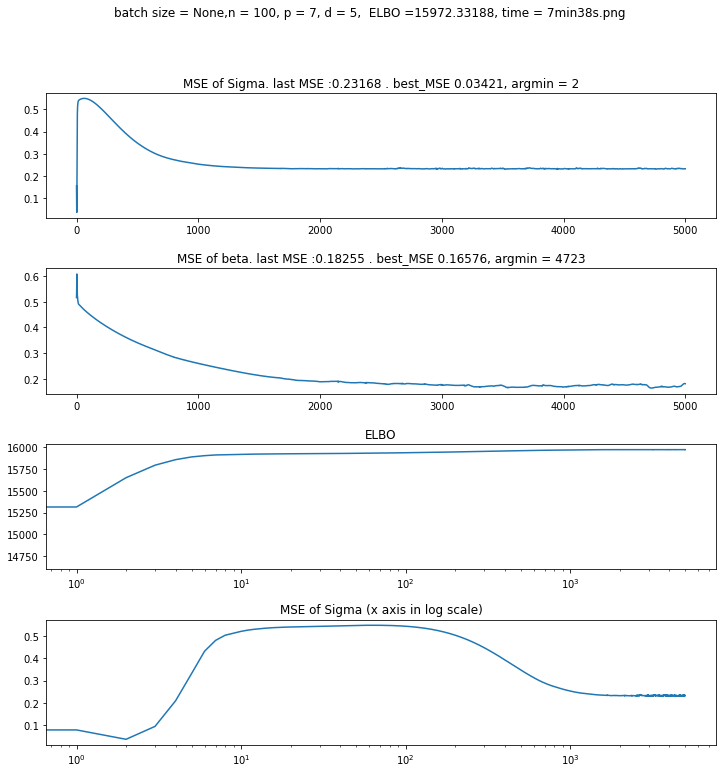

In [305]:

    
    
save_model(model, batch_size = None, time =  '7min38s')

